In [1]:
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniconda/base/envs/shapley/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [420]:
def regression_adjustment(baseline, explicand, model, num_samples, num_features):
    gen = np.random.Generator(np.random.PCG64())
    eval_model = lambda X : model.predict(X)
    num_samples //= 2
    # Learn a model to explain the predictions of the original model
    synth_data = np.tile(baseline, (num_samples, 1))
    for idx in range(num_samples):
        # randomly choose a subset of features to mask
        sample_size = gen.integers(1, num_features, endpoint=True)
        chosen = gen.choice(range(num_features), sample_size, replace=False)
        # create masked input as combination of baseline and explicand
        synth_data[idx, chosen] = explicand[0, chosen]

    predictions = eval_model(synth_data)
    shap_model = xgb.XGBRegressor(n_estimators=100, max_depth=4).fit(synth_data, predictions)
    chosens = np.zeros((num_samples, num_features))

    # Estimate shapley values for the explicand with regression adjustment
    synth_data = np.tile(baseline, (num_samples, 1))
    for idx in range(num_samples):
        sample_size = gen.integers(1, num_features, endpoint=True)
        chosen = gen.choice(range(num_features), sample_size, replace=False)
        chosens[idx, chosen] = 1
        synth_data[idx, chosen] = explicand[0, chosen]

    predictions = eval_model(synth_data)
    adjustment = shap_model.predict(synth_data)

    phi = np.zeros((2,num_features))
    num_values = np.zeros((2,num_features))
    for idx in range(num_samples):
        val = predictions[idx] - adjustment[idx]
        for i in range(num_features):
            sign = 1 if chosens[idx,i] == 1 else 0
            phi[sign,i] += val
            num_values[sign,i] += 1

    phi /= num_values
    phi = phi[1] - phi[0]
    return phi

def kernel_shap(baseline, explicand, model, num_samples, num_features):
    eval_model = lambda X : model.predict(X)

    explainer = shap.KernelExplainer(eval_model, baseline)
    shap_values = explainer.shap_values(explicand, nsamples=num_samples)
    return shap_values

def shapley_sampling(baseline, explicand, model, num_samples, num_features):
    eval_model = lambda X : model.predict(X)
    explainer = shap.SamplingExplainer(eval_model, baseline)
    shap_values = explainer.shap_values(explicand, nsamples=num_samples)
    return shap_values

def tree_shap(explicand, model):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(explicand)
    return shap_values

algorithms = {
    'Kernel SHAP': kernel_shap,
    'Sampling SHAP': shapley_sampling,
    'Regression SHAP': regression_adjustment
}

In [429]:
X, y = shap.datasets.communitiesandcrime()

# Train xgboost classifier
model = xgb.XGBRegressor(n_estimators=100, max_depth=4)
model.fit(X, y)
num_samples = 1000

eval_model = lambda X : model.predict(X)

baseline_idx = 100
explicand_idx = 10
baseline = X.iloc[baseline_idx].values.reshape(1, -1)
baseline = np.zeros_like(baseline)
#baseline = X.mean(axis=0).values.reshape(1, -1)
explicand = X.iloc[explicand_idx].values.reshape(1, -1)
num_features = X.shape[1]

results = {}
sample_sizes = [200, 300, 500, 1000, 2000, 5000, 10000]
true_shap_values = tree_shap(explicand, model)
for name, algorithm in algorithms.items():     
    results[name] = []

    for num_samples in sample_sizes:
        shap_values = algorithm(baseline, explicand, model, num_samples, num_features)
        error = ((shap_values - true_shap_values)**2).mean()
        results[name].append(error)

100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


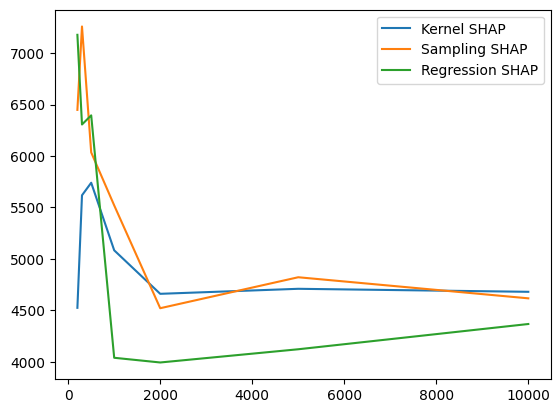

In [430]:
for name, errors in results.items():
    plt.plot(sample_sizes, errors, label=name)
plt.legend()

In [410]:



explainer = shap.SamplingExplainer(eval_model, baseline)
shap_values = explainer.shap_values(explicand, nsamples=300)
print(shap_values)

100%|██████████| 1/1 [00:00<00:00, 47.85it/s]

[[ -4.0114723    4.26971087  19.00228632  58.1592551    0.
   -3.63769206   0.         -11.18869115   0.           0.
   67.38929394 -27.46067675   0.          34.02786283   0.
  503.32765842   0.          72.29528108   3.88255125   6.61520736
   11.39699217  11.69989071   0.           1.40990114   0.
    0.          -7.19880338   6.42917496 -11.14583495  -1.13534835
   -3.37379346 -45.98689044   0.         -43.34532227  32.43324638
   23.07030613 -41.17122367 340.35349803   0.         136.33461446
   12.10261445  -1.83482839 191.96593688 291.5514333  -44.14380289
  -78.56218717   0.           9.47765289  -3.12732123 396.19993308
   47.44442369  65.23986816  15.95388794   0.           0.
    0.           0.           0.           0.          84.12222304
    5.96734746 -78.69950086 -21.19799805  15.48982205  -9.05459595
   47.66769409   0.         180.76826674  18.88839566   0.
   16.76332133   0.           0.         -55.15928936  -9.01249313
   12.64725083 -16.87774658 -15.32875902   

In [391]:
explainer = shap.TreeExplainer(model)
explainer.shap_values(explicand)

array([[ 5.84534216e+00, -6.05191886e-01,  4.94745865e+01,
         6.19117928e+01, -2.07110450e-01, -8.18207645e+00,
         4.20482111e+00,  6.90150499e-01, -4.42987204e-01,
        -8.19245625e+00,  2.43718987e+01, -4.27111506e-01,
         1.37663803e+01,  4.06307220e+01, -9.17813957e-01,
         1.64138367e+02,  6.24995279e+00,  1.51141977e+01,
         4.87994814e+00,  1.49512529e+01, -3.20037031e+00,
        -4.83448327e-01, -1.69432831e+01,  2.83146238e+00,
        -5.76462364e+00, -3.22441673e+00, -5.47381210e+00,
         2.36307220e+01,  1.30886135e+01, -3.71887112e+00,
        -2.13659072e+00, -2.00817890e+01, -1.07223904e+00,
        -9.49148750e+00,  1.71599007e+01,  1.56880474e+01,
        -2.12320280e+00,  1.72807755e+02, -2.41655707e+00,
         8.56737518e+01,  7.53931046e+00,  1.49550617e+00,
         1.25886238e+02,  3.45318726e+02,  9.48918724e+00,
        -4.36615219e+01, -3.80659819e+00,  1.06132784e+01,
        -3.75394897e+01,  3.56823822e+02,  2.72032471e+0

In [316]:
shap.force_plot(explainer.expected_value, shap_values, explicand)